In [1]:
import polars as pl
import pandas as pd
from tqdm import tqdm
import os
import json
import numpy as np
from catboost import CatBoostClassifier, CatBoostRanker, Pool, sum_models
from sklearn.utils import resample
from polimi.utils._inference import _inference
from ebrec.evaluation.metrics_protocols import *
from ebrec.utils._behaviors import sampling_strategy_wu2019
from polimi.utils._polars import reduce_polars_df_memory_size
from polimi.test.level_2_ensemble.build_model_predictions import require_subsampled_set, train_predict_model
from fastauc.fastauc.fast_auc import CppAuc
import os
import logging
from lightgbm import LGBMClassifier, LGBMRanker
from datetime import datetime
import argparse
import pandas as pd
import joblib
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing_extensions import List, Tuple, Dict, Type
import optuna
import polars as pl
from catboost import CatBoostClassifier, CatBoostRanker
from xgboost import XGBClassifier, XGBRanker
from polimi.utils._tuning_params import get_models_params
import gc
from polars import testing


2024-06-03 13:05:40.996518: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 13:05:43.390761: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
drop_me = ['Category_auto_Pct',
           'Category_bibliotek_Pct',
           'Category_biler_Pct',
           'Category_dagsorden_Pct',
           'Category_ferie_Pct',
           'Category_forbrug_Pct',
           'Category_haandvaerkeren_Pct',
           'Category_horoskoper_Pct',
           'Category_incoming_Pct',
           'Category_krimi_Pct',
           'Category_musik_Pct',
           'Category_nationen_Pct',
           'Category_nyheder_Pct',
           'Category_om_ekstra_bladet_Pct',
           'Category_opinionen_Pct',
           'Category_penge_Pct',
           'Category_plus_Pct',
           'Category_podcast_Pct',
           'Category_services_Pct',
           'Category_video_Pct',
           'Category_vin_Pct',
           'EVENTPct',
           'Entity_EVENT_Present',
           'Entity_PER_Present',
           'LOCPct',
           'MISCPct',
           'MaxReadTime',
           'MaxScrollPercentage',
           'MedianReadTime',
           'MedianScrollPercentage',
           'MostFrequentCategory',
           'MostFrequentHour',
           'MostFrequentWeekday',
           'NegativePct',
           'NeutralPct',
           'NumArticlesHistory',
           'NumberDifferentCategories',
           'ORGPct',
           'PERPct',
           'PRODPct',
           'PctCategoryMatches',
           'PctNotDefaultArticles',
           'PctStrongNegative',
           'PctStrongNeutral',
           'PctStrongPositive',
           'PositivePct',
           'TotalReadTime',
           'age',
           'clicked_count_l_inf_impression',
           'endorsement_20h_articleuser_l_inf_article_user',
           'endorsement_articleuser_macd',
           'endorsement_leak_macd',
           'entropy_impression_mean_JS',
           'entropy_impression_std_JS',
           'entropy_impression_topics_cosine',
           'entropy_impression_trendiness_score_3d_leak',
           'entropy_impression_trendiness_score_category',
           'gender',
           'is_already_seen_article',
           'is_inside_window_1',
           'kurtosis_impression_article_delay_hours',
           'kurtosis_impression_endorsement_10h',
           'kurtosis_impression_endorsement_10h_leak',
           'kurtosis_impression_inview_count',
           'kurtosis_impression_mean_JS',
           'kurtosis_impression_mean_topic_model_cosine',
           'kurtosis_impression_std_JS',
           'kurtosis_impression_topics_cosine',
           'kurtosis_impression_total_read_time',
           'kurtosis_impression_trendiness_score_3d',
           'kurtosis_impression_trendiness_score_3d_leak',
           'kurtosis_impression_trendiness_score_5d',
           'kurtosis_impression_trendiness_score_category',
           'last_session_duration',
           'last_session_time_hour_diff',
           'lda_0_history_mean',
           'lda_0_history_weighted_mean',
           'lda_1_history_mean',
           'lda_1_history_weighted_mean',
           'lda_2_history_mean',
           'lda_2_history_weighted_mean',
           'lda_3_history_mean',
           'lda_3_history_weighted_mean',
           'lda_4_history_mean',
           'lda_4_history_weighted_mean',
           'max_ner_item_knn_scores',
           'max_ner_svd_scores',
           'max_topic_model_cosine',
           'mean_ner_item_knn_scores',
           'mean_ner_svd_scores',
           'mean_prev_sessions_duration',
           'mean_topic_model_cosine',
           'mean_topic_model_cosine_l_inf_article',
           'mean_topic_model_cosine_l_inf_impression',
           'mean_topic_model_cosine_l_inf_user',
           'mean_topic_model_cosine_minus_median_impression',
           'mean_topic_model_cosine_rank_impression',
           'mean_user_trendiness_score',
           'min_JS',
           'min_topic_model_cosine',
           'num_topics',
           'postcode',
           'sentiment_label_diversity_impression',
           'skew_impression_inview_count',
           'skew_impression_mean_topic_model_cosine',
           'skew_impression_std_JS',
           'skew_impression_topics_cosine',
           'skew_impression_total_pageviews/inviews',
           'skew_impression_trendiness_score_3d',
           'skew_impression_trendiness_score_3d_leak',
           'skew_impression_trendiness_score_5d',
           'skew_impression_trendiness_score_category',
           'std_impression_mean_JS',
           'std_impression_mean_topic_model_cosine',
           'std_impression_std_JS',
           'std_impression_topics_cosine',
           'std_impression_trendiness_score_3d',
           'std_impression_trendiness_score_3d_leak',
           'std_impression_trendiness_score_5d',
           'std_impression_trendiness_score_category',
           'std_topic_model_cosine',
           'topics_cosine_l_inf_user',
           'total_ner_item_knn_scores',
           'total_ner_svd_scores',
           'total_pageviews_minus_median_impression',
           'total_pageviews_rank_impression',
           'total_read_time_l_inf_impression',
           'total_read_time_minus_median_impression',
           'total_read_time_rank_impression',
           'trendiness_score_1d/5d',
           'weighted_mean_topic_model_cosine',
           'window_0_history_length',
           'window_1_history_length',
           'window_2_history_length',
           'window_3_history_length',
           'window_topics_score']

In [3]:
RANKER = False
MODEL_LIST = ['catboost_ranker', 'catboost_classifier', 'mlp', 'GANDALF', 'wd', 'dcn'] # light_gbm_classifier
original_dataset_path = '/home/ubuntu/dataset/ebnerd_small/train/behaviors.parquet'
# level2_train_df=pl.read_parquet()
# level2_val_df=pl.read_parquet()

behaviors_train = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/train/behaviors.parquet')
history_train = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/train/history.parquet')
articles = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/articles.parquet')

article_features = articles.select(['article_id','total_inviews','total_pageviews'])

user_features = behaviors_train.select(['impression_id','user_id']).join(history_train.with_columns(
                        pl.col('article_id_fixed').list.len().alias('history_len')
                    ).select(['user_id','history_len']), on='user_id').drop('user_id')


In [4]:
def prediction_feature_eng(df, models):
    '''
        Do feature engineering of the predictions
    '''
    df = df.with_columns(
        *[
            (pl.col(f'prediction_{model}')-pl.col(f'prediction_{model}').min().over('impression_id')) / 
            (pl.col(f'prediction_{model}').max().over('impression_id')-pl.col(f'normalized_prediction_{model}').min().over('impression_id'))
            for model in models
        ]
    )
    
    return df

In [5]:
def load_predictions(dir, model_list):
    model_name = model_list[0]
    print(f'Loading Predictions for {model_name}')
    merged_df = reduce_polars_df_memory_size(pl.read_parquet(dir + f'/{model_name}_predictions.parquet'), verbose=0)\
        .sort(by=['impression_id','article'])
    original_shape = merged_df.shape[0]
    for df in range(1, len(model_list)):
        model_name = model_list[df]
        print(f'Loading Predictions for {model_name}')
        model_predictions = reduce_polars_df_memory_size(pl.read_parquet(dir + f'/{model_name}_predictions.parquet'),verbose=0).sort(by=['impression_id','article'])
        testing.assert_frame_equal(merged_df.select(['impression_id','article','target']), 
                                   model_predictions.select(['impression_id','article','target']))
        merged_df = merged_df.with_columns(
            model_predictions[f'prediction_{model_name}'].alias(f'prediction_{model_name}')
        )
        assert original_shape == merged_df.shape[0]
        
    return merged_df

In [14]:
def preprocessing(df, path_features):
    # MODEL_LIST = ['catboost_ranker', 'catboost_classifier', 'light_gbm_classifier', 'mlp', 'GANDALF', 'wd', 'dcn']
    MODEL_WEIGHTS = [0.20, 0.20, 0.15, 0.1, 0.20, 0.1, 0.05]
    for model in MODEL_LIST:
        if model in ['mlp', 'GANDALF', 'wd', 'dcn']:
            df = df.with_columns(
                    pl.col(f'prediction_{model}').list.first()    
                )
    df = df.with_columns(
        *[
            ((pl.col(f'prediction_{model}')-pl.col(f'prediction_{model}').min().over('impression_id')) / 
            (pl.col(f'prediction_{model}').max().over('impression_id')-pl.col(f'prediction_{model}').min().over('impression_id'))).alias(f'normalized_prediction_{model}')
            for model in MODEL_LIST
        ]
        ).with_columns(
            *[((pl.col(f'prediction_{model}')-pl.col(f'prediction_{model}').min().over('impression_id')) / 
            (pl.col(f'prediction_{model}').max().over('impression_id')-pl.col(f'prediction_{model}').min().over('impression_id'))).alias(f'art_norm_prediction_{model}')
            for model in MODEL_LIST]
        ).with_columns(
            *[(MODEL_WEIGHTS[i] * pl.col(f'normalized_prediction_{MODEL_LIST[i]}')).alias(f'prediction_hybrid_{MODEL_LIST[i]}') for i in range(len(MODEL_LIST))]
        ).with_columns(
                pl.sum_horizontal([f"prediction_hybrid_{model}" for model in MODEL_LIST]).alias('prediction_hybrid')
        ).drop( [f'prediction_hybrid_{model}' for model in MODEL_LIST])

    df = df.with_columns(
            *[pl.col(f'prediction_{model}').mean().over('impression_id').alias(f'mean_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
            *[pl.col(f'prediction_{model}').skew().over('impression_id').alias(f'skew_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
            *[pl.col(f'prediction_{model}').std().over('impression_id').alias(f'std_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
            *[pl.col(f'prediction_{model}').median().over('impression_id').alias(f'median_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])],
            *[pl.col(f'prediction_{model}').rank().over('impression_id').alias(f'rank_prediction_{model}') for model in (MODEL_LIST + ['hybrid']) ],
        ).rename({'prediction_hybrid' : 'normalized_prediction_hybrid'}).with_columns(   
            pl.mean_horizontal([f'art_norm_prediction_{model}' for model in MODEL_LIST]).alias('art_norm_horizontal_mean'),
            pl.min_horizontal([f'art_norm_prediction_{model}' for model in MODEL_LIST]).alias('art_norm_horizontal_min'),
            pl.max_horizontal([f'art_norm_prediction_{model}' for model in MODEL_LIST]).alias('art_norm_horizontal_max'), 
            pl.mean_horizontal([f'normalized_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('horizontal_mean'),
            pl.min_horizontal([f'normalized_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('horizontal_min'),
            pl.max_horizontal([f'normalized_prediction_{model}' for model in (MODEL_LIST + ['hybrid']) ]).alias('horizontal_max'),
            pl.mean_horizontal([f'rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('avg_rank_pos'),
            pl.min_horizontal([f'rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('min_rank_pos'),
            pl.max_horizontal([f'rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('max_rank_pos'),
        ).rename({'normalized_prediction_hybrid' : 'prediction_hybrid'}).with_columns(
            pl.col('impression_id').count().over('impression_id').alias('n_articles_impression')
        ).with_columns(
            *[(pl.col(f'rank_prediction_{model}')/pl.col('n_articles_impression')).alias(f'normalized_rank_prediction_{model}') for model in (MODEL_LIST + ['hybrid'])]
        ).with_columns(
            pl.mean_horizontal([f'normalized_rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('avg_norm_rank_pos'),
            pl.min_horizontal([f'normalized_rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('min_norm_rank_pos'),
            pl.max_horizontal([f'normalized_rank_prediction_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('max_norm_rank_pos'),
        )
        
    quantile_95 = df.quantile(quantile=0.95).select('horizontal_mean').item()

    df = df.with_columns(
        pl.col('horizontal_mean').mean().over('article').alias('mean_article_horizontal_mean'),
        pl.col('avg_rank_pos').le(3.5).cast(pl.UInt32).alias('is_avg_top_3'),
        pl.col('avg_rank_pos').le(1.5).cast(pl.UInt32).alias('is_avg_top_1'),
        pl.col('horizontal_mean').gt(quantile_95).cast(pl.UInt32).alias('over_95_qt'),
        *[pl.col(f'rank_prediction_{model}').le(3).cast(pl.UInt32).alias(f'is_top_3_{model}') for model in (MODEL_LIST + ['hybrid'])],
        *[pl.col(f'rank_prediction_{model}').le(1).cast(pl.UInt32).alias(f'is_top_1_{model}') for model in (MODEL_LIST + ['hybrid'])],
    ).with_columns(
        pl.sum_horizontal([f'is_top_3_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('agreement_top3'),
        pl.sum_horizontal([f'is_top_1_{model}' for model in (MODEL_LIST + ['hybrid'])]).alias('agreement_top1')
    ).with_columns(
        pl.col('agreement_top3')/pl.col('n_articles_impression').alias('normalized_agreement_top3'),
        pl.col('agreement_top1')/pl.col('n_articles_impression').alias('normalized_agreement_top1')
    ).drop([f'is_top_3_{model}' for model in (MODEL_LIST + ['hybrid'])] + [f'is_top_1_{model}' for model in (MODEL_LIST + ['hybrid'])])

    df = df.drop(columns=['target']).join(pl.read_parquet(path_features).drop(drop_me),on = ['impression_id', 'article'], how='left')
    
    df = df.with_columns(
        (pl.col('horizontal_mean') - pl.col('horizontal_mean').rolling_mean(window_size='1h' ,by='impression_time').over('article')).alias('roll_mean_1h_horizontal_mean'),
        (pl.col('horizontal_mean') - pl.col('horizontal_mean').rolling_mean(window_size='1d' ,by='impression_time').over('article')).alias('roll_mean_1d_horizontal_mean'),
        (pl.col('art_norm_horizontal_mean') - pl.col('art_norm_horizontal_mean').rolling_mean(window_size='1h' ,by='impression_time').over('article')).alias('roll_mean_1h_art_morm_horizontal_mean'),
        (pl.col('art_norm_horizontal_mean') - pl.col('art_norm_horizontal_mean').rolling_mean(window_size='1d' ,by='impression_time').over('article')).alias('roll_mean_1d_art_morm_horizontal_mean'),
        (pl.col('prediction_hybrid') - pl.col('prediction_hybrid').rolling_mean(window_size='1h' ,by='impression_time').over('article')).alias('roll_mean_1h_prediction_hybrid'),
        (pl.col('prediction_hybrid') - pl.col('prediction_hybrid').rolling_mean(window_size='1d' ,by='impression_time').over('article')).alias('roll_mean_1d_prediction_hybrid')
    )
    
    return df
    

In [10]:
level2_train_df = load_predictions('/home/ubuntu/experiments/hybrid_level2' + '/prediction_level_1_train', MODEL_LIST)

Loading Predictions for catboost_ranker
Loading Predictions for catboost_classifier
Loading Predictions for light_gbm_classifier
Loading Predictions for mlp
Loading Predictions for GANDALF
Loading Predictions for wd
Loading Predictions for dcn


In [15]:
level2_train_df = preprocessing(level2_train_df, '/home/ubuntu/experiments/preprocessing_train_small_new/train_ds.parquet')
level2_train_df

/tmp/ipykernel_774852/2481700410.py:68: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  df = df.drop(columns=['target']).join(pl.read_parquet(path_features).drop(drop_me),on = ['impression_id', 'article'], how='left')
/tmp/ipykernel_774852/2481700410.py:71: DeprecationWarning: Passing `by` to `rolling_mean` is deprecated. Instead of `rolling_mean(..., by='foo')`, please use `rolling_mean_by('foo', ...)`.
  (pl.col('horizontal_mean') - pl.col('horizontal_mean').rolling_mean(window_size='1h' ,by='impression_time').over('article')).alias('roll_mean_1h_horizontal_mean'),
/tmp/ipykernel_774852/2481700410.py:72: DeprecationWarning: Passing `by` to `rolling_mean` is deprecated. Instead of `rolling_mean(..., by='foo')`, please use `rolling_mean_by('foo', ...)`.
  (pl.col('horizontal_mean') - pl.col('horizontal_mean').rolling_mean(window_size='1d' ,by='impression_time').over('article')).alias('roll_mean_1d_horizontal_mean'),
/tmp/ipykernel_774852/24817

impression_id,article,prediction_catboost_ranker,prediction_catboost_classifier,prediction_light_gbm_classifier,prediction_mlp,prediction_GANDALF,prediction_wd,prediction_dcn,normalized_prediction_catboost_ranker,normalized_prediction_catboost_classifier,normalized_prediction_light_gbm_classifier,normalized_prediction_mlp,normalized_prediction_GANDALF,normalized_prediction_wd,normalized_prediction_dcn,art_norm_prediction_catboost_ranker,art_norm_prediction_catboost_classifier,art_norm_prediction_light_gbm_classifier,art_norm_prediction_mlp,art_norm_prediction_GANDALF,art_norm_prediction_wd,art_norm_prediction_dcn,prediction_hybrid,mean_prediction_catboost_ranker,mean_prediction_catboost_classifier,mean_prediction_light_gbm_classifier,mean_prediction_mlp,mean_prediction_GANDALF,mean_prediction_wd,mean_prediction_dcn,mean_prediction_hybrid,skew_prediction_catboost_ranker,skew_prediction_catboost_classifier,skew_prediction_light_gbm_classifier,skew_prediction_mlp,skew_prediction_GANDALF,…,entropy_impression_endorsement_10h_leak,entropy_impression_clicked_count,entropy_impression_inview_count,kurtosis_impression_total_pageviews/inviews,kurtosis_impression_total_pageviews,kurtosis_impression_total_inviews,kurtosis_impression_clicked_count,category_diversity_impression,article_type_diversity_impression,article_delay_hours_rank_impression,std_JS_rank_impression,mean_topics_mean_delay_hours_rank_impression,trendiness_score_3d_rank_impression,trendiness_score_5d_rank_impression,endorsement_10h_rank_impression,total_pageviews/inviews_rank_impression,mean_JS_rank_impression,topics_cosine_rank_impression,total_inviews_rank_impression,trendiness_score_category_rank_impression,endorsement_10h_leak_rank_impression,trendiness_score_3d_leak_rank_impression,clicked_count_rank_impression,inview_count_rank_impression,mean_JS_l_inf_user,std_JS_l_inf_user,article_delay_hours_l_inf_article,mean_JS_l_inf_article,std_JS_l_inf_article,topics_cosine_l_inf_article,endorsement_20h_articleuser_l_inf_articleuser,roll_mean_1h_horizontal_mean,roll_mean_1d_horizontal_mean,roll_mean_1h_art_morm_horizontal_mean,roll_mean_1d_art_morm_horizontal_mean,roll_mean_1h_prediction_hybrid,roll_mean_1d_prediction_hybrid
u32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,…,f32,f32,f32,f32,f32,f32,f32,u8,u8,u8,u8,u32,u8,u8,u8,u32,u8,u8,u32,u8,u8,u8,u32,u8,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f32,f32
157014,9220931,-0.728696,0.066032,0.052614,0.072851,0.01596,0.060296,0.042829,0.380989,0.083149,0.021865,0.079382,0.008885,0.080404,0.04975,0.380989,0.083149,0.021865,0.079382,0.008885,0.080404,0.04975,0.116351,0.211243,0.293418,0.291573,0.34884,0.282698,0.319979,0.36972,0.498184,-0.797654,0.079599,0.439657,0.05802,0.36421,…,-0.025538,NaN,-1.382191,-0.26666,-1.170422,-1.248418,NaN,5,1,8,1,8,6,6,8,null,6,3,null,8,8,6,1,1,0.082356,0.191675,0.993838,0.067231,0.161884,0.914953,0.5,0.0,0.0,0.0,0.0,0.0,0.0
157014,9743870,1.788228,0.554978,0.660882,0.703329,0.633078,0.557787,0.584779,1.0,0.997483,1.0,1.0,0.993045,0.871446,0.92013,1.0,0.997483,1.0,1.0,0.993045,0.871446,0.92013,0.981257,0.211243,0.293418,0.291573,0.34884,0.282698,0.319979,0.36972,0.498184,-0.797654,0.079599,0.439657,0.05802,0.36421,…,-0.025538,NaN,-1.382191,-0.26666,-1.170422,-1.248418,NaN,5,1,6,8,4,5,5,2,3,1,8,2,7,3,5,null,4,1.0,1.0,0.034483,0.388274,0.648861,0.511923,1.0,0.683104,0.683104,0.682579,0.682579,0.686774,0.686774
157014,9769605,-2.277812,0.021568,0.039017,0.018487,0.010388,0.009729,0.011851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.211243,0.293418,0.291573,0.34884,0.282698,0.319979,0.36972,0.498184,-0.797654,0.079599,0.439657,0.05802,0.36421,…,-0.025538,NaN,-1.382191,-0.26666,-1.170422,-1.248418,NaN,5,1,1,2,3,7,7,7,2,7,2,3,3,1,7,null,3,0.033275,0.247738,0.0,0.03876,0.196875,0.968013,1.0,0.0,0.0,0.0,0.0,0.0,0.0
157014,9776223,0.297555,0.218479,0.217298,0.197099,0.061223,0.44846,0.535743,0

In [ ]:
level2_train_df

impression_id,article,prediction_catboost_ranker,prediction_catboost_classifier,prediction_light_gbm_classifier,prediction_mlp,prediction_GANDALF,prediction_wd,prediction_dcn,normalized_prediction_catboost_ranker,normalized_prediction_catboost_classifier,normalized_prediction_light_gbm_classifier,normalized_prediction_mlp,normalized_prediction_GANDALF,normalized_prediction_wd,normalized_prediction_dcn,prediction_hybrid,mean_prediction_catboost_ranker,mean_prediction_catboost_classifier,mean_prediction_light_gbm_classifier,mean_prediction_mlp,mean_prediction_GANDALF,mean_prediction_wd,mean_prediction_dcn,mean_prediction_hybrid,skew_prediction_catboost_ranker,skew_prediction_catboost_classifier,skew_prediction_light_gbm_classifier,skew_prediction_mlp,skew_prediction_GANDALF,skew_prediction_wd,skew_prediction_dcn,skew_prediction_hybrid,std_prediction_catboost_ranker,std_prediction_catboost_classifier,std_prediction_light_gbm_classifier,std_prediction_mlp,…,entropy_impression_article_delay_hours,entropy_impression_total_pageviews,entropy_impression_total_inviews,entropy_impression_total_read_time,entropy_impression_endorsement_10h_leak,entropy_impression_clicked_count,entropy_impression_inview_count,kurtosis_impression_total_pageviews/inviews,kurtosis_impression_total_pageviews,kurtosis_impression_total_inviews,kurtosis_impression_clicked_count,category_diversity_impression,article_type_diversity_impression,article_delay_hours_rank_impression,std_JS_rank_impression,mean_topics_mean_delay_hours_rank_impression,trendiness_score_3d_rank_impression,trendiness_score_5d_rank_impression,endorsement_10h_rank_impression,total_pageviews/inviews_rank_impression,mean_JS_rank_impression,topics_cosine_rank_impression,total_inviews_rank_impression,trendiness_score_category_rank_impression,endorsement_10h_leak_rank_impression,trendiness_score_3d_leak_rank_impression,clicked_count_rank_impression,inview_count_rank_impression,mean_JS_l_inf_user,std_JS_l_inf_user,article_delay_hours_l_inf_article,mean_JS_l_inf_article,std_JS_l_inf_article,topics_cosine_l_inf_article,endorsement_20h_articleuser_l_inf_articleuser,roll_mean_1h_horizontal_mean,roll_mean_1d_horizontal_mean
u32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,u8,u8,u8,u8,u32,u8,u8,u8,u32,u8,u8,u32,u8,u8,u8,u32,u8,f32,f32,f32,f32,f32,f32,f32,f64,f64
157014,9220931,-0.728696,0.066032,0.052614,0.072851,0.01596,0.060296,0.042829,0.380989,0.083149,0.021865,0.079382,0.008885,0.080404,0.04975,0.116351,0.211243,0.293418,0.291573,0.34884,0.282698,0.319979,0.36972,0.498184,-0.797654,0.079599,0.439657,0.05802,0.36421,-0.01619,-0.293368,0.008674,1.27282,0.204572,0.213007,0.249876,…,3.142857,-1.170422,-1.248418,-0.177221,-0.025538,NaN,-1.382191,-0.26666,-1.170422,-1.248418,NaN,5,1,8,1,8,6,6,8,null,6,3,null,8,8,6,1,1,0.082356,0.191675,0.993838,0.067231,0.161884,0.914953,0.5,0.0,0.0
157014,9743870,1.788228,0.554978,0.660882,0.703329,0.633078,0.557787,0.584779,1.0,0.997483,1.0,1.0,0.993045,0.871446,0.92013,0.981257,0.211243,0.293418,0.291573,0.34884,0.282698,0.319979,0.36972,0.498184,-0.797654,0.079599,0.439657,0.05802,0.36421,-0.01619,-0.293368,0.008674,1.27282,0.204572,0.213007,0.249876,…,3.142857,-1.170422,-1.248418,-0.177221,-0.025538,NaN,-1.382191,-0.26666,-1.170422,-1.248418,NaN,5,1,6,8,4,5,5,2,3,1,8,2,7,3,5,null,4,1.0,1.0,0.034483,0.388274,0.648861,0.511923,1.0,0.683104,0.683104
157014,9769605,-2.277812,0.021568,0.039017,0.018487,0.010388,0.009729,0.011851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.211243,0.293418,0.291573,0.34884,0.282698,0.319979,0.36972,0.498184,-0.797654,0.079599,0.439657,0.05802,0.36421,-0.01619,-0.293368,0.008674,1.27282,0.204572,0.213007,0.249876,…,3.142857,-1.170422,-1.248418,-0.177221,-0.025538,NaN,-1.382191,-0.26666,-1.170422,-1.248418,NaN,5,1,1,2,3,7,7,7,2,7,2,3,3,1,7,null,3,0.033275,0.247738,0.0,0.03876,0.196875,0.968013,1.0,0.0,0.0
157014

In [ ]:
with open(os.path.join('/home/ubuntu/experiments/preprocessing_train_small_new', 'data_info.json')) as data_info_file:
        data_info = json.load(data_info_file)

categorical_columns = []
for col in data_info['categorical_columns']:
        if col not in drop_me:
                categorical_columns.append(col)

In [ ]:
if not RANKER:
    NPRATIO = 2
    starting_dataset =  pl.read_parquet(original_dataset_path).select(['impression_id','user_id','article_ids_inview','article_ids_clicked'])
    starting_dataset = starting_dataset.filter(pl.col('impression_id').is_in(level2_train_df['impression_id']))
    
    behaviors = pl.concat(
        rows.pipe(
            sampling_strategy_wu2019, npratio=NPRATIO, shuffle=False, with_replacement=True, seed=123
        ).explode('article_ids_inview').drop(columns =['article_ids_clicked']).rename({'article_ids_inview' : 'article'})\
        .with_columns(pl.col('user_id').cast(pl.UInt32),
                      pl.col('article').cast(pl.Int32))\
        
         for rows in tqdm(starting_dataset.iter_slices(1000), total=starting_dataset.shape[0] // 1000)
    ).drop('user_id')
    level2_train_df = behaviors.join(level2_train_df, on = ['impression_id','article'], how = 'left')

  0%|          | 0/98 [00:00<?, ?it/s]/tmp/ipykernel_563264/2316405466.py:7: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  rows.pipe(
99it [00:03, 26.43it/s]                        


In [ ]:
level2_train_df = reduce_polars_df_memory_size(level2_train_df)

categorical_columns = categorical_columns + ['is_avg_top_3', 'is_avg_top_1', 'over_95_qt']
if RANKER:
        level2_train_df = level2_train_df.sort(by='impression_id')
        groups = level2_train_df.select('impression_id').to_numpy().flatten()
        
if 'postcode' in level2_train_df.columns:
        level2_train_df = level2_train_df.with_columns(pl.col('postcode').fill_null(5))
if 'article_type' in level2_train_df.columns:
        level2_train_df = level2_train_df.with_columns(pl.col('article_type').fill_null('article_default'))    
if 'impression_time' in level2_train_df.columns:
        level2_train_df = level2_train_df.drop(columns = ['impression_time'])    
                   
level2_train_df = level2_train_df.to_pandas()
level2_train_df[categorical_columns] = level2_train_df[categorical_columns].astype('category')

group_ids = level2_train_df['impression_id'].to_frame()
if 'user_id' in level2_train_df.columns:
        level2_train_df = level2_train_df.drop(columns = ['user_id'])
level2_train_df = level2_train_df.drop(columns=['impression_id', 'article'])
    
X_train = level2_train_df.drop(columns=['target'])
y_train = level2_train_df['target']

del level2_train_df
gc.collect()

Memory usage of dataframe is 296.97 MB
Memory usage after optimization is: 255.15 MB
Decreased by 14.1%


/tmp/ipykernel_563264/2990928865.py:13: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  level2_train_df = level2_train_df.drop(columns = ['impression_time'])


0

In [ ]:
if RANKER:
    params = {
        'iterations': 2000,
        'depth': 8,
        'colsample_bylevel': 0.5
    }
    catboost = CatBoostRanker(**params, cat_features=categorical_columns) #, cat_features=data_info['categorical_columns'])
    catboost.fit(X_train, y_train, group_id=group_ids, verbose=50)
else :
    params = {
        "iterations": 1000,
        "subsample": 0.5,
        "rsm": 0.7
    }
    catboost = CatBoostClassifier(**params, cat_features=categorical_columns)  #, cat_features=data_info['categorical_columns'])
    catboost.fit(X_train, y_train, verbose=50)

Learning rate set to 0.11739
0:	learn: 0.6350597	total: 131ms	remaining: 2m 10s
50:	learn: 0.4417253	total: 5.71s	remaining: 1m 46s
100:	learn: 0.4308221	total: 11.4s	remaining: 1m 41s
150:	learn: 0.4228869	total: 17.6s	remaining: 1m 38s
200:	learn: 0.4165418	total: 23.2s	remaining: 1m 32s
250:	learn: 0.4116208	total: 28.9s	remaining: 1m 26s
300:	learn: 0.4072978	total: 34.9s	remaining: 1m 21s
350:	learn: 0.4032884	total: 40.4s	remaining: 1m 14s
400:	learn: 0.3998440	total: 46s	remaining: 1m 8s
450:	learn: 0.3966637	total: 51.8s	remaining: 1m 3s
500:	learn: 0.3937320	total: 57.4s	remaining: 57.1s
550:	learn: 0.3908067	total: 1m 3s	remaining: 51.4s
600:	learn: 0.3880142	total: 1m 8s	remaining: 45.6s
650:	learn: 0.3855240	total: 1m 14s	remaining: 39.8s
700:	learn: 0.3830097	total: 1m 19s	remaining: 34.1s
750:	learn: 0.3807194	total: 1m 25s	remaining: 28.3s
800:	learn: 0.3783463	total: 1m 31s	remaining: 22.6s
850:	learn: 0.3761538	total: 1m 36s	remaining: 17s
900:	learn: 0.3738956	total: 

In [ ]:
from catboost import Pool

if not RANKER:
    train_pool = Pool(X_train, y_train, cat_features=categorical_columns) #, cat_features=data_info['categorical_columns'])
    feature_importances = catboost.get_feature_importance(train_pool)

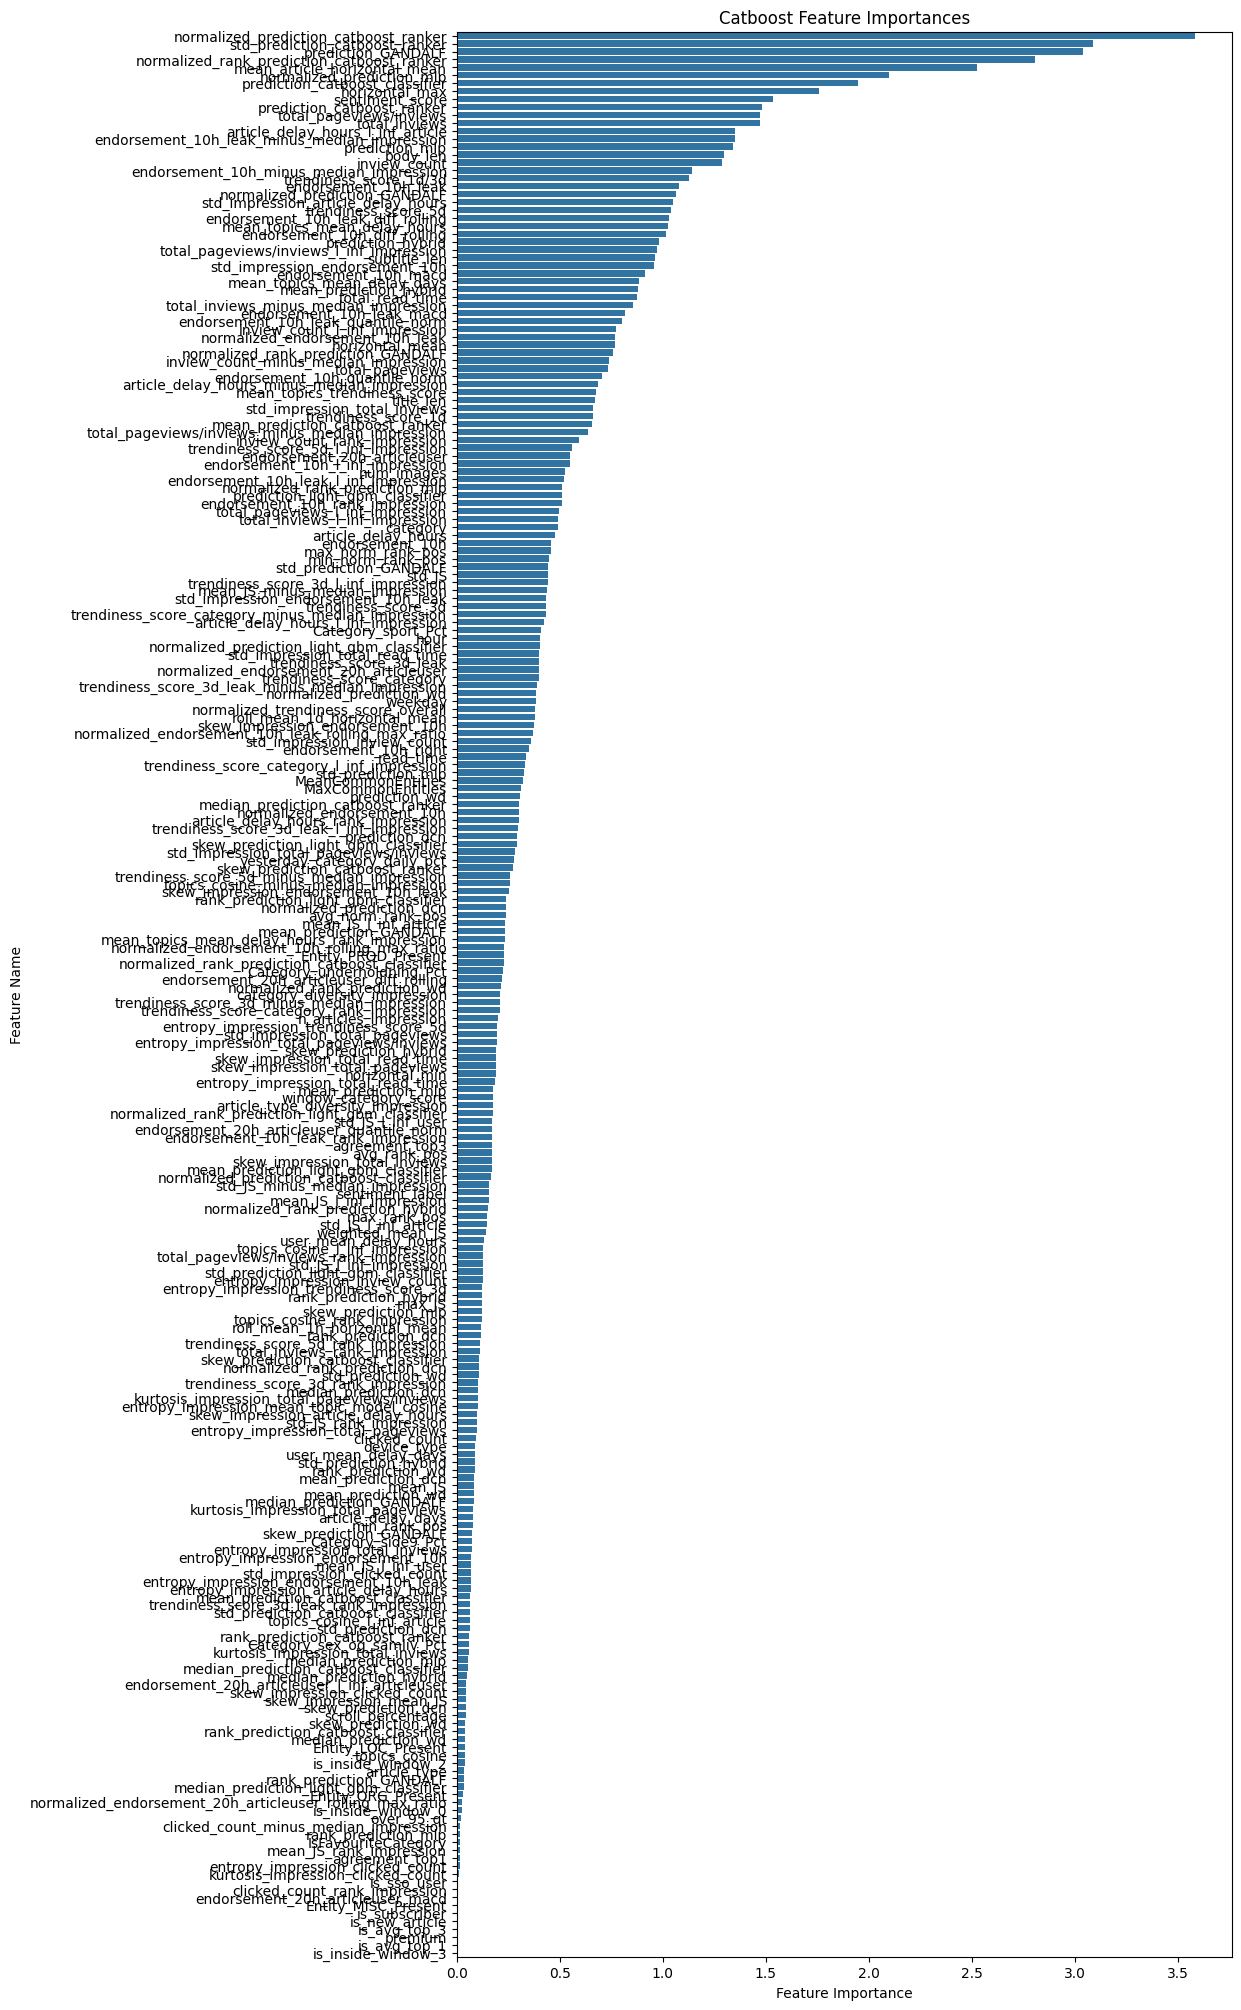

In [ ]:
if not RANKER:
    sorted_importances = np.argsort(feature_importances)[::-1]

    plt.figure(figsize=(10, 25))
    sns.barplot(x=feature_importances[sorted_importances], y=np.array(X_train.columns)[sorted_importances])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Name')
    plt.title('Catboost Feature Importances')

In [ ]:

behaviors_train = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/validation/behaviors.parquet')
history_train = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/validation/history.parquet')

article_features = articles.select(['article_id','total_inviews','total_pageviews'])

user_features = behaviors_train.select(['impression_id','user_id']).join(history_train.with_columns(
                        pl.col('article_id_fixed').list.len().alias('history_len')
                    ).select(['user_id','history_len']), on='user_id').drop('user_id')


In [ ]:
level2_val_df = load_predictions('/home/ubuntu/experiments/hybrid_level2' + '/prediction_level_1_validation', MODEL_LIST)

Loading Predictions for catboost_ranker
Loading Predictions for catboost_classifier
Loading Predictions for light_gbm_classifier
Loading Predictions for mlp
Loading Predictions for GANDALF
Loading Predictions for wd
Loading Predictions for dcn


In [ ]:
level2_val_df = preprocessing(level2_val_df, '/home/ubuntu/experiments/preprocessing_validation_small_new/validation_ds.parquet')

/tmp/ipykernel_563264/1561139075.py:61: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  df = df.drop(columns=['target']).join(pl.read_parquet(path_features).drop(drop_me),on = ['impression_id', 'article'], how='left')
/tmp/ipykernel_563264/1561139075.py:64: DeprecationWarning: Passing `by` to `rolling_mean` is deprecated. Instead of `rolling_mean(..., by='foo')`, please use `rolling_mean_by('foo', ...)`.
  (pl.col('horizontal_mean') - pl.col('horizontal_mean').rolling_mean(window_size='1h' ,by='impression_time').over('article')).alias('roll_mean_1h_horizontal_mean'),
/tmp/ipykernel_563264/1561139075.py:65: DeprecationWarning: Passing `by` to `rolling_mean` is deprecated. Instead of `rolling_mean(..., by='foo')`, please use `rolling_mean_by('foo', ...)`.
  (pl.col('horizontal_mean') - pl.col('horizontal_mean').rolling_mean(window_size='1d' ,by='impression_time').over('article')).alias('roll_mean_1d_horizontal_mean')
sys:1: UserWarning: Series i

In [ ]:
level2_val_df

impression_id,article,prediction_catboost_ranker,prediction_catboost_classifier,prediction_light_gbm_classifier,prediction_mlp,prediction_GANDALF,prediction_wd,prediction_dcn,normalized_prediction_catboost_ranker,normalized_prediction_catboost_classifier,normalized_prediction_light_gbm_classifier,normalized_prediction_mlp,normalized_prediction_GANDALF,normalized_prediction_wd,normalized_prediction_dcn,prediction_hybrid,mean_prediction_catboost_ranker,mean_prediction_catboost_classifier,mean_prediction_light_gbm_classifier,mean_prediction_mlp,mean_prediction_GANDALF,mean_prediction_wd,mean_prediction_dcn,mean_prediction_hybrid,skew_prediction_catboost_ranker,skew_prediction_catboost_classifier,skew_prediction_light_gbm_classifier,skew_prediction_mlp,skew_prediction_GANDALF,skew_prediction_wd,skew_prediction_dcn,skew_prediction_hybrid,std_prediction_catboost_ranker,std_prediction_catboost_classifier,std_prediction_light_gbm_classifier,std_prediction_mlp,…,entropy_impression_article_delay_hours,entropy_impression_total_pageviews,entropy_impression_total_inviews,entropy_impression_total_read_time,entropy_impression_endorsement_10h_leak,entropy_impression_clicked_count,entropy_impression_inview_count,kurtosis_impression_total_pageviews/inviews,kurtosis_impression_total_pageviews,kurtosis_impression_total_inviews,kurtosis_impression_clicked_count,category_diversity_impression,article_type_diversity_impression,article_delay_hours_rank_impression,std_JS_rank_impression,mean_topics_mean_delay_hours_rank_impression,trendiness_score_3d_rank_impression,trendiness_score_5d_rank_impression,endorsement_10h_rank_impression,total_pageviews/inviews_rank_impression,mean_JS_rank_impression,topics_cosine_rank_impression,total_inviews_rank_impression,trendiness_score_category_rank_impression,endorsement_10h_leak_rank_impression,trendiness_score_3d_leak_rank_impression,clicked_count_rank_impression,inview_count_rank_impression,mean_JS_l_inf_user,std_JS_l_inf_user,article_delay_hours_l_inf_article,mean_JS_l_inf_article,std_JS_l_inf_article,topics_cosine_l_inf_article,endorsement_20h_articleuser_l_inf_articleuser,roll_mean_1h_horizontal_mean,roll_mean_1d_horizontal_mean
u32,i32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,u8,u8,u8,u8,u32,u8,u8,u8,u32,u8,u8,u32,u8,u8,u8,u32,u8,f32,f32,f32,f32,f32,f32,f32,f64,f64
96791,9783865,-0.581865,0.07266,0.093698,0.164932,0.042458,0.064278,0.076475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.33145,0.239505,0.272763,0.359217,0.28837,0.270774,0.241343,0.540928,-0.665784,-0.454278,-0.69147,-0.489786,0.193835,0.185605,0.104031,-0.361365,0.575732,0.115924,0.112246,0.127801,…,-1.833333,-0.255067,-0.8471,-0.464928,-1.66624,null,-0.602295,-0.383784,-0.255067,-0.8471,null,2,1,1,1,5,4,4,4,2,5,1,2,5,1,5,null,2,0.564538,0.483503,0.066667,0.19009,0.32674,0.736162,0.6,0.0,0.0
96791,9784591,0.332211,0.176555,0.271684,0.405962,0.292777,0.205723,0.201436,0.578127,0.356872,0.57581,0.693803,0.487722,0.327027,0.369704,0.491484,0.33145,0.239505,0.272763,0.359217,0.28837,0.270774,0.241343,0.540928,-0.665784,-0.454278,-0.69147,-0.489786,0.193835,0.185605,0.104031,-0.361365,0.575732,0.115924,0.112246,0.127801,…,-1.833333,-0.255067,-0.8471,-0.464928,-1.66624,null,-0.602295,-0.383784,-0.255067,-0.8471,null,2,1,3,4,1,2,2,1,1,2,3,1,1,2,2,null,1,0.845408,1.0,0.075472,0.236126,0.526822,0.41698,0.75,-0.213782,-0.213782
96791,9784679,0.542811,0.313949,0.306928,0.387571,0.257047,0.334262,0.274459,0.711326,0.828814,0.689829,0.640863,0.418105,0.624212,0.585748,0.650918,0.33145,0.239505,0.272763,0.359217,0.28837,0.270774,0.241343,0.540928,-0.665784,-0.454278,-0.69147,-0.489786,0.193835,0.185605,0.104031,-0.361365,0.575732,0.115924,0.112246,0.127801,…,-1.833333,-0.255067,-0.8471,-0.464928,-1.66624,null,-0.602295,-0.383784,-0.255067,-0.8471,null,2,1,3,4,1,2,2,2,5,2,3,3,1,4,2,null,3,0.845408,1.0,0.083333,0.236126,0.526822,

In [ ]:
if 'postcode' in level2_val_df.columns:
        level2_val_df = level2_val_df.with_columns(pl.col('postcode').fill_null(5))
if 'article_type' in level2_val_df.columns:
        level2_val_df = level2_val_df.with_columns(pl.col('article_type').fill_null('article_default'))  
if 'impression_time' in level2_val_df.columns:
        level2_val_df = level2_val_df.drop(columns = ['impression_time']) 
        
level2_val_df = level2_val_df.to_pandas()
level2_val_df[categorical_columns] = level2_val_df[categorical_columns].astype('category')

X_val = level2_val_df[X_train.columns]
evaluation_ds = pl.from_pandas(level2_val_df[['impression_id', 'article', 'target']])
    
if RANKER:
    prediction_ds = evaluation_ds.with_columns(pl.Series(catboost.predict(X_val)).alias('prediction'))\
        .group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
else : 
    prediction_ds = evaluation_ds.with_columns(pl.Series(catboost.predict_proba(X_val)[:, 1]).alias('prediction'))\
        .group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))

/tmp/ipykernel_563264/1757020590.py:6: DeprecationWarning: named `columns` param is deprecated; use positional `*args` instead.
  level2_val_df = level2_val_df.drop(columns = ['impression_time'])


In [ ]:
cpp_auc = CppAuc()
result = np.mean(
        [cpp_auc.roc_auc_score(np.array(y_t).astype(bool), np.array(y_s).astype(np.float32)) 
            for y_t, y_s in zip(prediction_ds['target'].to_list(), 
                                prediction_ds['prediction'].to_list())]
    )
print(result)

0.8157146064937584


In [ ]:
def optimize_parameters(X_train: pd.DataFrame, y_train: pd.DataFrame, X_val: pd.DataFrame, evaluation_ds: pl.DataFrame, 
                        categorical_features: List[str], group_ids: pd.DataFrame, model_class: Type = CatBoostClassifier, 
                        study_name: str = 'catboost_cls_tuning', n_trials: int = 100, storage: str = None) -> Tuple[Dict, pd.DataFrame]:    
    def objective_function(trial: optuna.Trial):
        params = get_models_params(trial, model_class, categorical_features)
        model = model_class(**params)
        if model_class == CatBoostRanker:
            model.fit(X_train, y_train, group_id=group_ids['impression_id'], verbose=50)
        elif model_class in [XGBRanker, LGBMRanker]:
            model.fit(X_train, y_train, group=group_ids.groupby('impression_id')['impression_id'].count().values)
        elif model_class == LGBMClassifier:
            model.fit(X_train, y_train)
        else:
            model.fit(X_train, y_train, verbose=100)
        if model_class in [CatBoostRanker, XGBRanker, LGBMRanker]:
            prediction_ds = evaluation_ds.with_columns(pl.Series(model.predict(X_val)).alias('prediction')) \
                .group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
        else:
            prediction_ds = evaluation_ds.with_columns(pl.Series(model.predict_proba(X_val)[:, 1]).alias('prediction')) \
                .group_by('impression_id').agg(pl.col('target'), pl.col('prediction'))
        cpp_auc = CppAuc()
        return np.mean(
            [cpp_auc.roc_auc_score(np.array(y_t).astype(bool), np.array(y_s).astype(np.float32)) 
                for y_t, y_s in zip(prediction_ds['target'].to_list(), 
                                    prediction_ds['prediction'].to_list())]
        )
        
    study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage, load_if_exists=True)
    study.optimize(objective_function, n_trials=n_trials, n_jobs=1)
    return study.best_params, study.trials_dataframe()

In [ ]:
# best_params, trials_df = optimize_parameters(X_train=X_train, y_train=y_train, X_val=X_val, evaluation_ds=evaluation_ds,
#                                                  categorical_features=categorical_columns, group_ids=group_ids, model_class=CatBoostClassifier,
#                                                  study_name='test', n_trials=200, storage=None)